In [1]:
import copy
import numpy as np
import scipy
from scipy.spatial.distance import cdist

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
rng = np.random.default_rng(15234)

## Setup


### Code


In [4]:
class Sensor:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.coords = (x, y)
        
    def observe_sources(self, source_xs, source_ys, source_ls, theta_bins=np.linspace(-np.pi, np.pi, 128)):
        
        # Center on source
        source_xs = copy.copy(source_xs - self.x)
        source_ys = copy.copy(source_ys - self.y)
        
        # Calculate angles
        thetas = np.arctan2(source_ys, source_xs)
        thetas = thetas.flatten()
        
        # Calculate brightness scalings
        rs = np.sqrt(source_xs**2. + source_ys**2.)
        surface_areas = np.pi * rs**2.
        
        # Get weights
        weights = copy.copy(source_ls.flatten())
        surface_areas = surface_areas.flatten()
        weights[weights>0.] /= surface_areas[weights>0.]
        
        fluxs, theta_bins = np.histogram(
            thetas.flatten(),
            bins=theta_bins,
            weights=weights,
        )
        thetas = 0.5 * ( theta_bins[:-1] + theta_bins[1:] )
        
        return fluxs, thetas
    
    def map_from_observations(self, thetas, fluxs, xs, ys, kind='nearest'):
        
        xs = copy.copy(xs - self.x)
        ys = copy.copy(ys - self.y)

        thetas_per_coord = np.arctan2(ys, xs)
        above_bounds = thetas_per_coord > thetas.max()
        below_bounds = thetas_per_coord < thetas.min()
        in_bounds = np.invert(above_bounds) & np.invert(below_bounds)
        
        flux_mapping = scipy.interpolate.interp1d(thetas, fluxs, kind=kind)
        
        fluxs_per_coord = np.full(thetas_per_coord.shape, np.nan)
        fluxs_per_coord[above_bounds] = fluxs[-1]
        fluxs_per_coord[below_bounds] = fluxs[0]
        fluxs_per_coord[in_bounds] = flux_mapping(thetas_per_coord[in_bounds])

        rs = np.sqrt(xs**2. + ys**2.)
        surface_areas = np.pi * rs**2.

        allowable_fluxs = fluxs_per_coord * surface_areas

        return allowable_fluxs

In [5]:
class SensorArray:
    
    def __init__(self, sensors):
        self.sensors = sensors
        
    def observe_sources(self, source_xs, source_ys, source_ls, theta_bins=np.linspace(-np.pi, np.pi, 128)):
        
        self.sensor_fluxs = []
        for i, sensor_i in enumerate(self.sensors):
            fluxs, thetas = sensor_i.observe_sources(source_xs, source_ys, source_ls, theta_bins)
            self.sensor_fluxs.append(fluxs)
        self.thetas = thetas
        
        return self.sensor_fluxs, self.thetas
        
    def plot_observations(self, ax, sensor_fluxs, thetas, **pcolor_kwargs):
        
        n_sensors = len(sensor_fluxs)
        if n_sensors == 1:
            fluxs = sensor_fluxs[0]
            tileshape = (2,1)
            flux_arr = np.tile(fluxs, tileshape)
            thetas_tiled = np.tile(thetas, tileshape)
            display_ys = np.array( [ [ 0., ] * fluxs.size, [ 1., ] * fluxs.size ] )
        else:
            flux_arr = np.array(sensor_fluxs)
            thetas_tiled = np.tile(thetas,(n_sensors,1))
            display_ys = np.tile(np.arange(n_sensors), (flux_arr.shape[1],1)).transpose()
            
        pcolor_kwargs_used = {
            'cmap': 'Greys_r',
        }
        pcolor_kwargs_used.update(pcolor_kwargs)
            
        ax.pcolormesh(
            -thetas_tiled,
            display_ys,
            flux_arr,
            **pcolor_kwargs_used
        )
        
    def estimate_allowed_luminosities_on_grid(self, grid_res=1024):
        
        self.xs_for_estimate = np.linspace(xs.min(), xs.max(), grid_res)
        self.ys_for_estimate = np.linspace(ys.min(), ys.max(), grid_res)
        xs_grid, ys_grid = np.meshgrid(self.xs_for_estimate, self.ys_for_estimate)
        
        self.allowed_luminosities = []
        for i, sensor_i in enumerate(s_arr.sensors):
            allowed_luminosities_i = sensor_i.map_from_observations(self.thetas, self.sensor_fluxs[i], xs_grid, ys_grid)
            self.allowed_luminosities.append(allowed_luminosities_i)
            
        return self.allowed_luminosities

# Simplified


### Parameters


In [6]:
palette = sns.color_palette('deep')

In [7]:
brightness_norm = matplotlib.colors.LogNorm(vmin=0.001, vmax=1., clip=True)

In [8]:
# Generate source grid
source_grid_res = (16,16)
source_type = 'point'
n_lights = 5
light_luminosities = rng.uniform(1., 1., n_lights)

source_grid = np.zeros(source_grid_res)
xs = np.arange(source_grid.shape[0])
ys = np.arange(source_grid.shape[1])
x_lights = np.random.choice(xs, n_lights)
y_lights = np.random.choice(ys, n_lights)
for i in range(n_lights):
    
    if source_type == 'point':
        source_grid[x_lights[i],y_lights[i]] = light_luminosities[i]
    elif source_type == 'normal':
        x_pdf = scipy.stats.norm(x_lights[i]).pdf(xs)
        y_pdf = scipy.stats.norm(y_lights[i]).pdf(ys)
        x_pdf_mesh, y_pdf_mesh = np.meshgrid(x_pdf, y_pdf)
        source_grid += light_luminosities[i] * (x_pdf_mesh*y_pdf_mesh)

In [9]:
# Generate sensors
n_sensors = 3

sensor_xs = np.random.choice(xs, n_sensors)
sensor_ys = np.random.choice(ys, n_sensors)
sensors = []
for i in range(n_sensors):
    sensors.append(Sensor(sensor_xs[i], sensor_ys[i]))
s_arr = SensorArray(sensors)

In [10]:
# Have sensors view the sources
xs_grid, ys_grid = np.meshgrid(xs, ys)
sensor_fluxs, thetas = s_arr.observe_sources(xs_grid, ys_grid, source_grid)

## View Sources and Sensors


### View


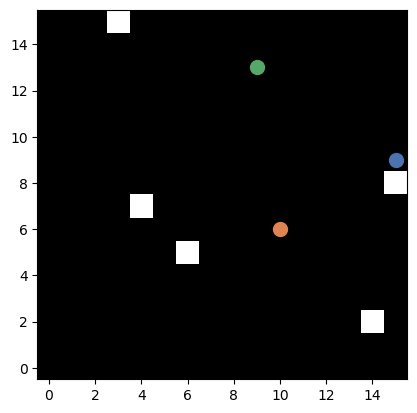

In [11]:
fig = plt.figure()
ax  = plt.gca()

ax.pcolormesh(
    xs,
    ys,
    source_grid,
    cmap = 'Greys_r',
    norm = brightness_norm,
)

for i, sensor_i in enumerate(s_arr.sensors):
    ax.scatter(
        sensor_i.x,
        sensor_i.y,
        color = palette[i],
        s = 100,
    )

ax.set_aspect('equal')

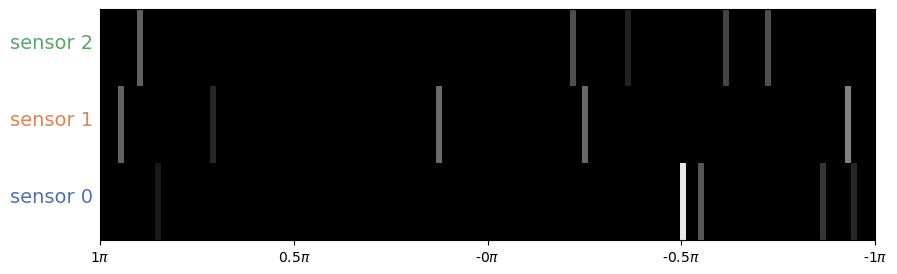

In [12]:
fig = plt.figure(figsize=(10,len(s_arr.sensors)))
ax = plt.gca()

s_arr.plot_observations(ax, s_arr.sensor_fluxs, s_arr.thetas, norm=brightness_norm)

# X ticks
dx = 0.25
xtick_multiples = np.array([-1, -0.5, 0., 0.5, 1.])
xticks = xtick_multiples * np.pi
xtick_labels = [ '{:.2g}'.format( -_ ) + r'$\pi$' for _ in xtick_multiples ]
xticks = ax.set_xticks(xticks, xtick_labels)

# Y labels
ax.tick_params(left=False, labelleft=False)
for i, sensor_i in enumerate(s_arr.sensors):
    ax.annotate(
        'sensor {}'.format(i),
        xy = (-np.pi,i),
        xycoords = 'data',
        xytext = (-5,0),
        textcoords = 'offset points',
        color = palette[i],
        ha = 'right',
        fontsize = 14,
    )

## Recreate Light Source


In [13]:
allowed_ls = s_arr.estimate_allowed_luminosities_on_grid()

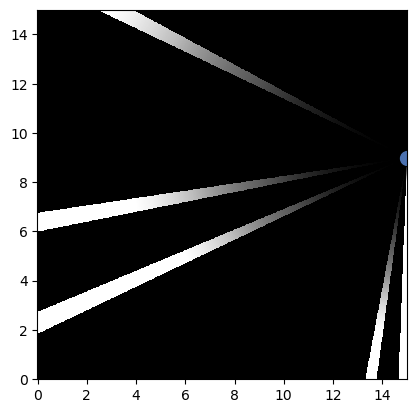

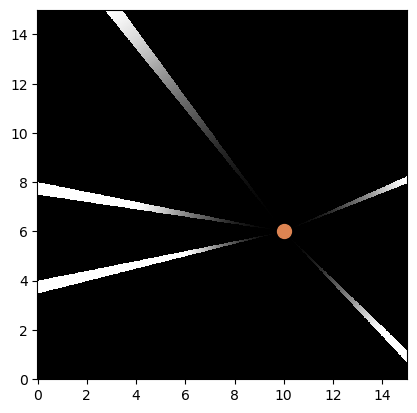

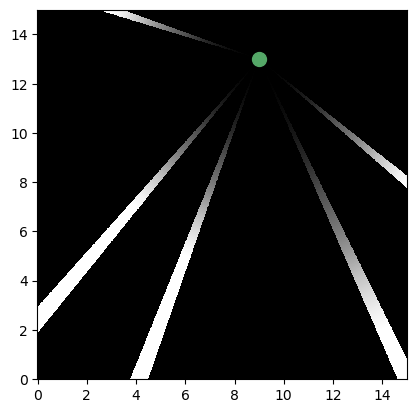

In [14]:
for i, allowed_l in enumerate(allowed_ls):
    
    fig = plt.figure()
    ax  = plt.gca()

    ax.pcolormesh(
        s_arr.xs_for_estimate,
        s_arr.ys_for_estimate,
        allowed_l,
        cmap = 'Greys_r',
        norm = matplotlib.colors.Normalize(0, 1),
    )

    ax.scatter(
        s_arr.sensors[i].x,
        s_arr.sensors[i].y,
        color = palette[i],
        s = 100,
    )

    ax.set_aspect('equal')

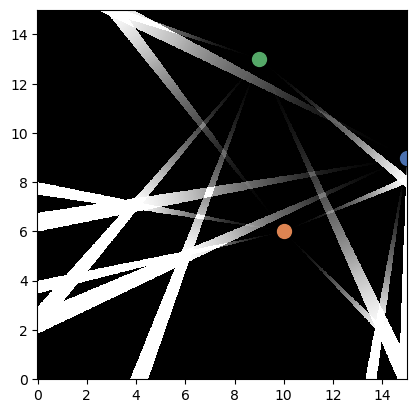

In [15]:

fig = plt.figure()
ax  = plt.gca()

ax.pcolormesh(
    s_arr.xs_for_estimate,
    s_arr.ys_for_estimate,
    np.array(allowed_ls).sum(axis=0),
    cmap = 'Greys_r',
    norm = matplotlib.colors.Normalize(0, 1),
)
for i, allowed_l in enumerate(allowed_ls):

    ax.scatter(
        s_arr.sensors[i].x,
        s_arr.sensors[i].y,
        color = palette[i],
        s = 100,
    )

ax.set_aspect('equal')

# Real Data


In [1]:
from night_horizons.data_io import GDALDatasetIO

In [3]:
fp = (
    '/Users/Shared/data/other/'
    'KX10_GIU_20230320_W88.35_N41.09_202300123136_L4A_B_LH.tif'
)

In [4]:
data = GDALDatasetIO().load_data(fp)

In [5]:
data.SetProjection()
data.GetGeoTransform()

(349458.9511574486, 10.0, 0.0, 4759968.933047194, 0.0, -10.0)